<a href="https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/notebooks/gene_expression/Gene_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACE2 Gene Modulation

### *Ted Natoli*


The goal of this notebook is to illustrate basic usage of the [`cmapR`](https://github.com/cmap/cmapR) package. As a case study, we'll be identifying compounds that down-regulate the expression of ACE2, the receptor that mediates SARS-CoV-2 cell entry.



## Setup

First we'll download the data files that we'll use in this notebook. This takes about a minute.

In [1]:
# download data files and assets for this notebook
system("wget --quiet -O - https://s3.amazonaws.com/repo-assets.clue.io/genemod_assets_covid.tar.gz |tar zx -C .")

Here we'll install the packages required for this notebook, most notably `cmapR`. Please note that this can take a few minutes.

In [ ]:
install.packages("BiocManager")
BiocManager::install("rhdf5")
devtools::install_github("cmap/cmapR", ref="lincs-workshop-2020")

# The above commands install a stripped-down version of cmapR and
# its main dependency, the rhdf5 package. The stripped-down version
# still retains most of the core functionality of the package and is
# therefore suitable for the purpose of demonstration. In practice the
# full version of cmapR can be installed with the following command:
# BiocManager::install("cmapR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'rhdf5'

also installing the dependencies ‘Rhdf5lib’, ‘rhdf5filters’


Old packages: 'backports', 'gitcreds', 'htmlwidgets', 'jsonlite', 'ps',
  'usethis', 'foreign', 'nlme'




data.table (NA -> 1.13.4) [CRAN]


Installing 1 packages: data.table

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpVX5bS5/remotes3a1fbe693b/cmap-cmapR-0fa345d/DESCRIPTION’
─  preparing ‘cmapR’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘cmapR_1.2.1.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# add pheatmap package for making heatmaps
install.packages("pheatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# load cmapR library
library(cmapR)

# load data.table for fast reading of text files
library(data.table)

# load pheatmap for plotting heatmaps
library(pheatmap)

Set up paths for matrix and metadata. In this case, we'll be using a subset of the current public release of CMap L1000 data in order to minimize network file transfer. The full version of the data can be accessed at [clue.io](https://clue.io).

In [ ]:
ds_path <- "level5_trt_cp_A375_for_genemod_n25057x12328.gctx"
siginfo_path <- "siginfo.txt"
geneinfo_path <- "geneinfo.txt"

## Slicing

Load the metadata for all CMap signatures. We're doing this because we don't want to load all signatures at once. The matrix is too large. So instead, we'll figure out the specific set of signatures beforehand and then extract only those. To do this we need both the `siginfo.txt` file, which contains metadata for the level 5 matrix columns.

In [ ]:
# read signature annotations (corresponding to columns of level 5 matrix)
siginfo <- data.table::fread(siginfo_path)

In [ ]:
str(siginfo)

Classes ‘data.table’ and 'data.frame':	1165466 obs. of  34 variables:
 $ sig_id                      : chr  "GPR001_XC_XH:GALR2_GALP:1_H" "ASG002_BEN_24H:D22" "ASG002_BEN_24H:E06" "ASG002_BEN_24H:G01" ...
 $ pert_id                     : chr  "GALR2_GALP" "BRD-K92723993" "BRD-K44876623" "BRD-K04548931" ...
 $ cmap_name                   : chr  "GALR2_GALP" "imatinib" "zolpidem" "epirubicin" ...
 $ pert_type                   : chr  "trt_cp" "trt_cp" "trt_cp" "trt_cp" ...
 $ cell_iname                  : chr  "A549" "BEN" "BEN" "BEN" ...
 $ bead_batch                  : chr  "b41" "b35" "b35" "b35" ...
 $ nearest_dose                : num  4 10 0.12 10 1.11 10 1.11 10 3.33 12.5 ...
 $ pert_dose                   : num  3.75 10 0.1 10 1 10 1 10 3 12.5 ...
 $ pert_dose_unit              : chr  "uM" "uM" "uM" "uM" ...
 $ pert_idose                  : chr  "4 uM" "10 uM" "0.12 uM" "10 uM" ...
 $ pert_itime                  : chr  "1 h" "24 h" "24 h" "24 h" ...
 $ pert_time                  

We'll also read the metadata for the genes (rows) of the level 5 matrix. This will allow us to slice along the row dimension as well.

In [ ]:
# make sure we read the gene_ids as characters
geneinfo <- data.table::fread(geneinfo_path, colClasses = c("gene_id" = "character"))

In [ ]:
str(geneinfo)

Classes ‘data.table’ and 'data.frame':	12328 obs. of  7 variables:
 $ gene_id      : chr  "750" "6315" "7503" "8552" ...
 $ gene_symbol  : chr  "GAS8-AS1" "ATXN8OS" "XIST" "INE1" ...
 $ ensembl_id   : chr  "ENSG00000221819" "" "ENSG00000229807" "ENSG00000224975" ...
 $ gene_title   : chr  "GAS8 antisense RNA 1" "ATXN8 opposite strand lncRNA" "X inactive specific transcript" "inactivation escape 1" ...
 $ gene_type    : chr  "ncRNA" "ncRNA" "ncRNA" "ncRNA" ...
 $ src          : chr  "NCBI" "NCBI" "NCBI" "NCBI" ...
 $ feature_space: chr  "inferred" "inferred" "inferred" "inferred" ...
 - attr(*, ".internal.selfref")=<externalptr> 


Designate my gene of interest using its gene symbol.



In [ ]:
my_gene <- "MYC"

Look up the corresponding gene_id, since this will correspond to row ids in the data matrix.

In [ ]:
my_gene_id <- geneinfo[gene_symbol==my_gene]$gene_id

Figure out list of signature ids (sig_ids) corresponding to compounds in the cell line A375, where the given signature had exactly 3 replicates. This is somewhat arbitrary but useful in reducing the number of signatures we're dealing with.

In [ ]:
sigs_of_interest <- siginfo[pert_type == "trt_cp" &
                  cell_iname == "A375" & 
                  nsample == 3]
sig_ids <- sigs_of_interest$sig_id

How many did we get?

In [ ]:
length(sig_ids)

[1] 25057

Ok, this is a pretty large number. We can pair it down by considering only those signatures marked as exemplars, which will ensure we get only one signature for each compound / cell line combination. These exemplar signatures were selected as those with the best replicate recall and are indicated by the field `is_ncs_exemplar`.

In [ ]:
sigs_of_interest <- siginfo[pert_type == "trt_cp" &
                  cell_iname == "A375" & 
                  nsample == 3 &
                  is_ncs_exemplar == 1]
sig_ids <- sigs_of_interest$sig_id
length(sig_ids)

[1] 6206

Ok that's a more manageable number. Now slice out the corresponding rows and columns from the data matrix using `parse.gctx`, which will return an object of class GCT. Make sure to cast the gene_id as a character so it's not mistakenly interpreted as an integer index.

In [ ]:
ds <- cmapR::parse_gctx(ds_path,
                        rid = my_gene_id,
                        cid = sig_ids)

reading level5_trt_cp_A375_for_genemod_n25057x12328.gctx

done



Let's take a look at the structure of the object we can do this by simply typing its name.

In [ ]:
ds

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1, 1:6206] 0.0335 -0.5179 -0.0626 -0.6042 -0.1061 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr "4609"
  .. .. ..$ : chr [1:6206] "LPROT002_A375_6H:BRD-K93480852:0.1" "MOAR005_A375_24H:D05" "MOAR005_A375_24H:A09" "MOAR005_A375_24H:E13" ...
  ..@ rid    : chr "4609"
  ..@ cid    : chr [1:6206] "LPROT002_A375_6H:BRD-K93480852:0.1" "MOAR005_A375_24H:D05" "MOAR005_A375_24H:A09" "MOAR005_A375_24H:E13" ...
  ..@ rdesc  :'data.frame':	1 obs. of  1 variable:
  .. ..$ id: chr "4609"
  ..@ cdesc  :'data.frame':	6206 obs. of  1 variable:
  .. ..$ id: chr [1:6206] "LPROT002_A375_6H:BRD-K93480852:0.1" "MOAR005_A375_24H:D05" "MOAR005_A375_24H:A09" "MOAR005_A375_24H:E13" ...
  ..@ version: chr(0) 
  ..@ src    : chr "level5_trt_cp_A375_for_genemod_n25057x12328.gctx"

Note that the matrix only has one row, because we only requested data for a single gene.

## Analysis

We're interested in the data matrix, located in the slot `@mat`. Let's look at the distribution of z-scores. We'll add some vertical lines to indicate the thresholds for modulation.

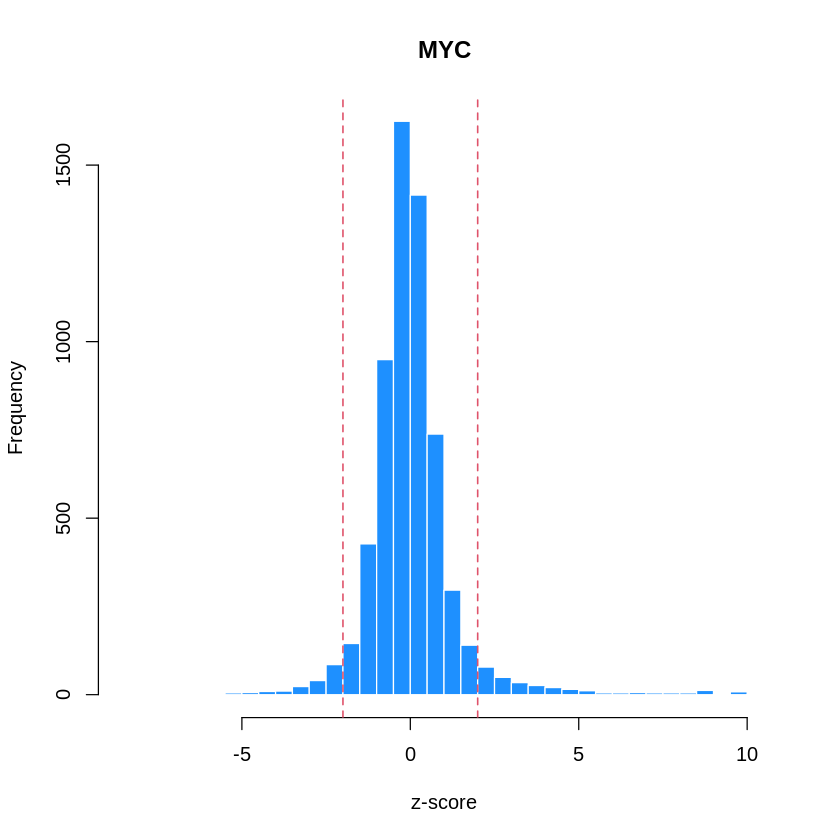

In [ ]:
hist(ds@mat, col="dodgerblue", border="white", breaks=30, main=my_gene, xlab="z-score")
abline(v=2, lty=2, col=2, lwd=1.3)
abline(v=-2, lty=2, col=2, lwd=1.3)

Lets identify the signatures in which the gene was significantly modulated.

In [ ]:
mod_idx <- which(abs(ds@mat[1, ]) > 2)

How many are there?

In [ ]:
length(mod_idx)

[1] 472

Let's compare these signatures to each other to see whether they have any similarity. For comparison, we'll include roughly the same number of signatures in which the gene was **NOT** modulated.

In [ ]:
non_mod_idx <- which(abs(ds@mat[1, ]) < 0.06)
length(non_mod_idx)

[1] 382

Good, this is roughly an equal number. Slice out the signatures from the matrix, restricting to landmark space (i.e. directly measured genes only).

In [ ]:
lm_ids <- geneinfo[feature_space == "landmark"]$gene_id
ds2 <- parse_gctx(ds_path, rid=lm_ids,
                  cid=c(names(mod_idx), names(non_mod_idx)))


reading level5_trt_cp_A375_for_genemod_n25057x12328.gctx

done



Compute all pairwise correlations between signatures.

In [ ]:
corr <- cor(ds2@mat, method="spearman")

Cluster the correlations, overlaying a color bar indicating the degree of modulation of our gene of interest.

In [ ]:
mod_df <- data.frame(abs_zscore=abs(ds@mat[, c(mod_idx, non_mod_idx)]))
rownames(mod_df) <- c(names(mod_idx), names(non_mod_idx))

Plot as a heatmap using the `pheatmap` package.

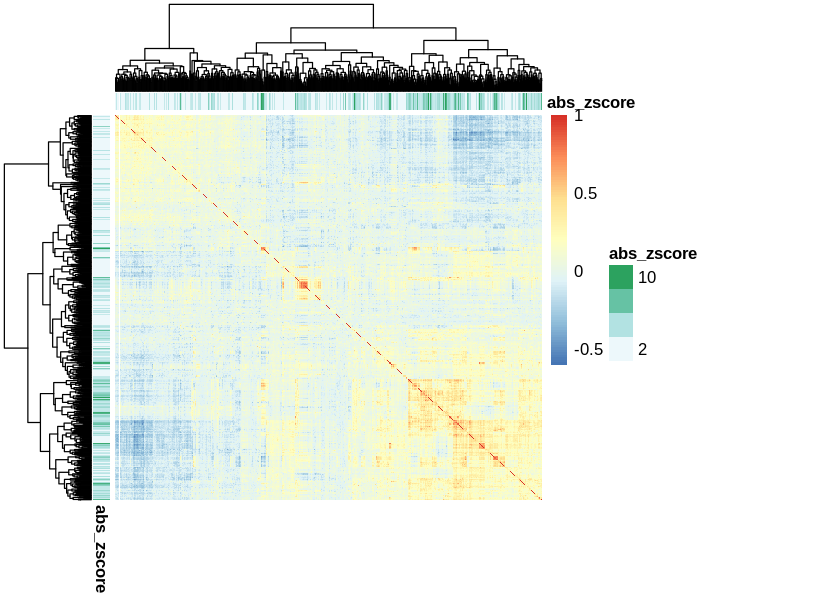

In [ ]:
pheatmap::pheatmap(corr, annotation_row=mod_df, annotation_col=mod_df,
                  show_rownames=F, show_colnames=F)

Seems like we do see ~2 clusters which roughly correspond to the signatures in which our gene is modulated, as indicated by the color bar on the margins. Not perfect but definitely a trend.

Do the signatures that modulate MYC do so specifically? Let's look at the number of genes modulated in each class.

In [ ]:
ss_list <- list(
    mod = siginfo[sig_id %in% names(mod_idx)]$ss_ngene,
    non_mod = siginfo[sig_id %in% names(non_mod_idx)]$ss_ngene
)

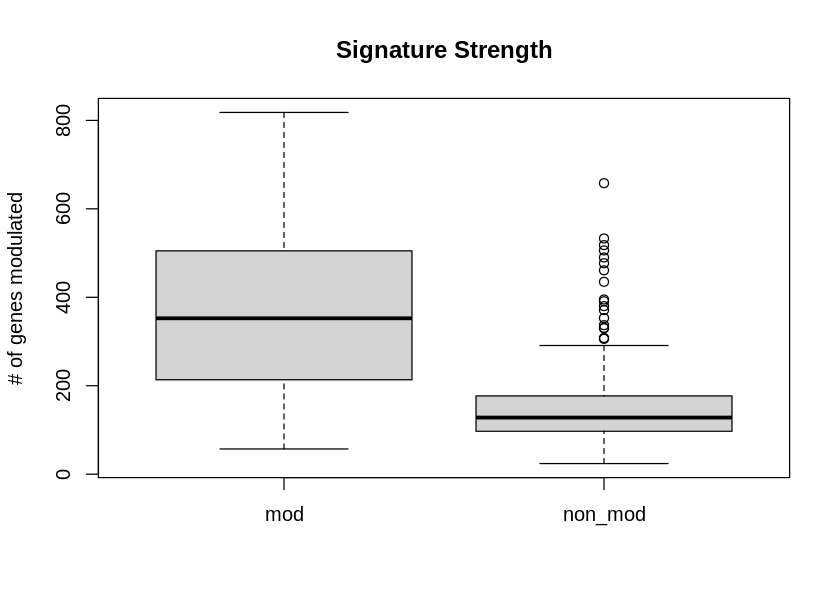

In [ ]:
boxplot(ss_list, main="Signature Strength",  ylab="# of genes modulated")

In general those compounds that modulate MYC tend to modulate lots of genes, but there are a few that are more selective. Let's look at those, and restrict to those that have a canonical name so we might have a sense of what they actually do.

In [ ]:
siginfo[sig_id %in% names(mod_idx) &
          ss_ngene <= 120
          & !grepl("^BRD-", cmap_name),
          .(sig_id, pert_id, cmap_name, ss_ngene)][
    order(ss_ngene, decreasing=F)]

sig_id,pert_id,cmap_name,ss_ngene
<chr>,<chr>,<chr>,<int>
CPC005_A375_6H:BRD-A37347161-003-01-8:10,BRD-A37347161,BRL-52537,66
REP.A002_A375_24H:D17,BRD-K16195444,oxymetazoline,68
CPC011_A375_6H:BRD-K81169441-236-06-6:10,BRD-K81169441,cerivastatin,79
CPC005_A375_6H:BRD-A15034104-002-03-6:10,BRD-A15034104,bergenin,86
MOAR003_A375_24H:G22,BRD-K90948141,indiplon,87
CPC015_A375_6H:BRD-K57033106-048-03-6:10,BRD-K57033106,tripelennamine,93
CPC017_A375_6H:BRD-A68891053-001-01-2:10,BRD-A68891053,BW-B70C,96
MOAR003_A375_24H:C12,BRD-K34332569,imidapril,99
MOAR003_A375_24H:I07,BRD-K96550715,linagliptin,108


Cervistatin is near the top of the list. Let's see which direction it regulates MYC. [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491823/) suggests that perhaps statins up-regulate a specific microRNA that reduces MYC expression, albeit in a very different cell type.

In [ ]:
# use the sig_id of cervistatin to look up its impact (z-score) on MYC
round(ds@mat[, "CPC011_A375_6H:BRD-K81169441-236-06-6:10"], 2)

[1] -2.55

Indeed cervistatin down-regulates MYC, which may be in agreement with the finding in the paper above.